In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/pjwalapuram/text-analysis.git

Cloning into 'text-analysis'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 90 (delta 43), reused 67 (delta 27), pack-reused 0
Receiving objects: 100% (90/90), 16.24 KiB | 8.12 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
%cd text-analysis

/content/text-analysis


In [ ]:
!ls -l
#!pip install -r requirements.txt

total 32
-rw-r--r-- 1 root root  524 Sep 17 03:09 Dockerfile
-rw-r--r-- 1 root root 3444 Sep 17 03:09 main.py
-rw-r--r-- 1 root root 7170 Sep 17 03:09 openapi_spec.json
-rw-r--r-- 1 root root  952 Sep 17 03:09 README.md
-rw-r--r-- 1 root root 1156 Sep 17 03:09 requirements.txt
drwxr-xr-x 2 root root 4096 Sep 17 03:09 src
-rw-r--r-- 1 root root 3103 Sep 17 03:09 tests.py


In [ ]:
import src.data_reader as data_reader
import sqlite3
from src.preprocess import Preprocess
from src.model import LDA

In [ ]:
def test_csv(filepath):
	data = data_reader.get_csv_data(filepath, ['companyName', 'filedAt', 'Section1', 'Section1A', 'Section7'])
	merged = data_reader.concatenate_columns(data, ['Section1', 'Section1A', 'Section7'])
	year = data['filedAt'].apply(lambda x: x.split('-')[0])
	new_field = [("Year", x) for x in year] + [("Year", x) for x in year] + [("Year", x) for x in year]
	return merged, new_field

In [ ]:
data, year = test_csv("https://storage.googleapis.com/iig-ds-test-data/all_filings_and_sections.csv")

In [ ]:
sample_data = data[:100]
sample_year = year[:100]
preprocessor = Preprocess(sample_data)
preprocessor.lemmatize_and_filter()
sentiments = preprocessor.get_sentiment()

Preprocessing...


100%|██████████| 100/100 [03:12<00:00,  1.92s/it]


In [ ]:
!rm gic_text_analysis.db

In [ ]:
import src.database as database
database.save_documents_to_db(preprocessor.sentences, "gic_text_analysis.db")
database.save_additional_field_to_db(year, "gic_text_analysis.db")
database.save_sentiments_to_db(sentiments, "gic_text_analysis.db")

In [ ]:
def test_model_fit(vectorized_texts, feature_names):
	build_model = LDA(vectorized_texts, feature_names, n_components=5, max_iter=10, learning_method='online')
	build_model.fit_model()
	topics = build_model.get_topics(5)
	database.save_topics_to_db(topics, "gic_text_analysis.db")
	assignments = build_model.get_topic_assignments()
	database.save_assignments_to_db(assignments, "gic_text_analysis.db")

In [ ]:
def test_tfidf_vectorizer(filtered_texts):
	vectorized_texts = filtered_texts.vectorize_tfidf()
	return vectorized_texts, filtered_texts.tfidf.get_feature_names_out()

In [ ]:
v_texts, features = test_tfidf_vectorizer(preprocessor)
test_model_fit(v_texts, features)

Running Model...
Done, took 71.32 seconds


In [ ]:
import pandas as pd

con = sqlite3.connect("gic_text_analysis.db")
res = pd.read_sql_query("SELECT document, topic, sentiment, fieldvalue FROM documents, lda_topics, assigned_topics, sentiment_analysis, additional_fields WHERE documents.document_id = sentiment_analysis.document_id AND documents.document_id = assigned_topics.document_id AND assigned_topics.topic_id = lda_topics.topic_id AND documents.text_id = additional_fields.text_id", con)


In [ ]:
import seaborn

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
topics = pd.read_sql_query("SELECT topic from lda_topics", con)
print(topics)
by_topic_and_year = pd.read_sql_query("SELECT lda_topics.topic_id, COUNT(topic), fieldvalue FROM documents, lda_topics, assigned_topics, additional_fields WHERE documents.document_id = assigned_topics.document_id AND assigned_topics.topic_id = lda_topics.topic_id AND documents.text_id = additional_fields.text_id GROUP BY fieldvalue, topic", con)


                                          topic
0      service customer product pharmacy system
1       president inc united international vice
2         health care employee program hospital
3  table_start medicare revenue table_end group
4          regulation state law subject federal


Topics around healthcare, law, business are major themes

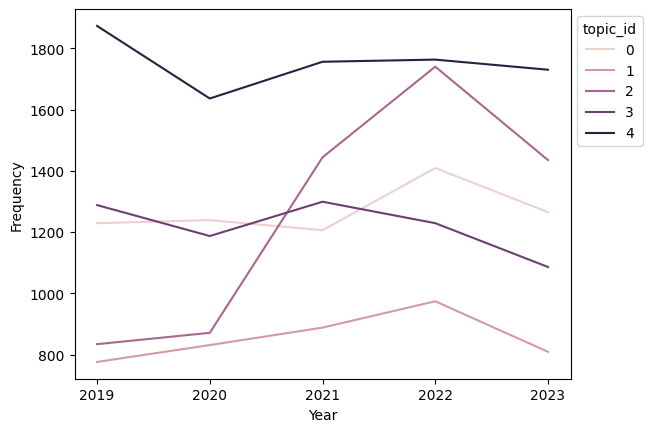

In [ ]:
ax = seaborn.lineplot(data=by_topic_and_year, y='COUNT(topic)', x='fieldvalue', hue='topic_id')
ax.set(xlabel='Year', ylabel='Frequency')
seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

Topics 1 and 3 are emerging topics, while Topics 0 and 2 are on a downward trend. Topic 4 is emerging except for a small dip more recently.

In [ ]:
most_freq_sentiment_by_topic = pd.read_sql_query("SELECT lda_topics.topic, sentiment FROM documents, lda_topics, assigned_topics, sentiment_analysis WHERE documents.document_id = assigned_topics.document_id AND assigned_topics.topic_id = lda_topics.topic_id AND documents.document_id = sentiment_analysis.document_id GROUP BY topic ORDER BY COUNT(sentiment)", con)
print(most_freq_sentiment_by_topic)

                                          topic sentiment
0       president inc united international vice   neutral
1  table_start medicare revenue table_end group  negative
2         health care employee program hospital  positive
3      service customer product pharmacy system  positive
4          regulation state law subject federal   neutral


Topics trending higher (4, 2) are positive or neutral. Topics trending very low are negative (1). Health care topic in particular sees a sharp rise in 2020 that continues until 2022 before falling, very likely due to COVID.